In [1]:
import pandas as pd

import numpy as np

In [2]:

import tensorflow as tf

In [3]:
import torch 
import torch.nn as nn

import pickle
import os
import random
from time import time

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [4]:
!! unzip data.zip

['Archive:  data.zip',
 '   creating: data/',
 '  inflating: data/nice_embed_tsne.csv  ',
 '  inflating: data/acid_properties.csv  ',
 '  inflating: data/family_classification_sequences.tab  ',
 '  inflating: data/family_classification_metadata.tab  ']

In [5]:
seq_df = pd.read_table('data/family_classification_sequences.tab')
seq_df.head()

Sequences
0  MAFSAEDVLKEYDRRRRMEALLLSLYYPNDRKLLDYKEWSPPRVQV...
1  MSIIGATRLQNDKSDTYSAGPCYAGGCSAFTPRGTCGKDWDLGEQT...
2  MQNPLPEVMSPEHDKRTTTPMSKEANKFIRELDKKPGDLAVVSDFV...
3  MDSLNEVCYEQIKGTFYKGLFGDFPLIVDKKTGCFNATKLCVLGGK...
4  MEAKNITIDNTTYNFFKFYNINQPLTNLKYLNSERLCFSNAVMGKI...

In [10]:
def make_codones(sseq):
    crop = len(sseq) % 3
    cropped_seq = sseq[:-crop] if crop > 0 else sseq

    return [cropped_seq[i:i+3] for i in range(0, len(cropped_seq), 3)]

def seq_to3(seq):
    splittings = [make_codones(seq[i:]) for i in range(3)]
    return splittings

def create_all_codones(df):
    codones = []

    for i in range(df.shape[0]):
        row = df.iloc[i, :][0]
        codones.extend(seq_to3(row))
    return codones

In [11]:
def read_or_create(read_path, producer):
    if os.path.isfile(read_path):
        print('reading', read_path)
        with open(read_path, 'rb') as fp:
            return pickle.load(fp)
    result = producer()
    print('saving', read_path)
    with open(read_path, 'wb') as fp:
        pickle.dump(result, fp)
    return result

In [12]:
all_codones = read_or_create(read_path='data/all_codones.pickle',
                             producer= lambda: create_all_codones(seq_df))

reading data/all_codones.pickle


In [13]:
def generate_sample(index_words_list, context_window_size):
    """ Form training pairs according to the skip-gram model. """
    for index_words in index_words_list:
        for index, center in enumerate(index_words):
            context = random.randint(1, context_window_size)
            # get a random target before the center word
            for target in index_words[max(0, index - context): index]:
                yield center, target
            # get a random target after the center wrod
            for target in index_words[index + 1: index + context + 1]:
                yield center, target


def get_batch(iterator, batch_size):
    """ Group a numerical stream into batches and yield them as Numpy arrays. """
    while True:
        center_batch = np.zeros(batch_size, dtype=np.int32)
        target_batch = np.zeros(batch_size, dtype=np.int32)
        for index in range(batch_size):
            center_batch[index], target_batch[index] = next(iterator)
        yield center_batch, target_batch


def flatten(x):
    return [item for sublist in x for item in sublist]


def cod_to_dict(cod, dictionary):
    return [dictionary[key] for key in cod]

def make_dictionary(all_codones):
    flat_codones = flatten(all_codones)
    unique_codones = set(flat_codones)
    dictionary = {cod: i for i, cod in enumerate(unique_codones)}
    return dictionary

def process_data(all_codones, dictionary, batch_size, skip_window):
    cod_dicts = [cod_to_dict(cod, dictionary) for cod in all_codones]
    single_gen = generate_sample(cod_dicts, context_window_size=skip_window)
    batch_gen = get_batch(single_gen, batch_size=batch_size)
    return batch_gen

def encode_one_hot(indices, vocab_size, long=False):
    res = np.zeros((vocab_size, indices.shape[0]))
    for i, ind in enumerate(indices):
        res[ind][i] = 1.0
    return torch.LongTensor(res)if long else torch.Tensor(res) 

In [14]:
dictionary = make_dictionary(all_codones)

In [117]:
BATCH_SIZE = 128
SKIP_WINDOW = 12  # the context window

batch_gen = process_data(all_codones, dictionary, BATCH_SIZE, SKIP_WINDOW)

In [118]:
######################

In [242]:
class SkipGram(nn.Module):
    def __init__(self, vocab_size, embed_size, batch_size, num_sampled, learning_rate):
        super(SkipGram, self).__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.batch_size = batch_size
        self.num_sampled = num_sampled
        self.lr = learning_rate
        
        self.embed_matrix = nn.Embedding(self.vocab_size, self.embed_size, sparse=True)
        self.embed_matrix.weight = nn.Parameter(torch.FloatTensor(self.vocab_size, self.embed_size).uniform_(-1, 1))
        
        self.not_embed_matrix = nn.Embedding(self.vocab_size, self.embed_size, sparse=True)
        self.not_embed_matrix.weight = nn.Parameter(torch.FloatTensor(self.vocab_size, self.embed_size).uniform_(-1, 1))
                
        self.optimizer = torch.optim.SparseAdam(self.parameters(), lr=learning_rate)
#         self.optimizer = torch.optim.SGD(self.parameters(), lr=learning_rate)
        
    def forward(self, x):
        centers = x[0]
        targets = x[1]
        noise = torch.autograd.Variable(torch.Tensor(self.batch_size, self.num_sampled)\
                                        .uniform_(0, self.vocab_size - 1).long())
        
        centers_emb = self.embed_matrix(centers)
        targets_ebm2 = self.not_embed_matrix(targets)
        noise_emb = self.not_embed_matrix(noise)
        
        main_loss = (centers_emb * targets_ebm2).sum(1).squeeze().sigmoid().log()
        noise_loss = torch.bmm(noise_emb, centers_emb.unsqueeze(2)).neg().sigmoid().log().sum(1).squeeze()
        loss = main_loss + noise_loss
        
        return -loss.sum() / self.batch_size
        


In [256]:
VOCAB_SIZE = 9424
EMBED_SIZE = 100  # dimension of the word embedding vectors
NUM_SAMPLED = 2  # Number of negative examples to sample.
LEARNING_RATE = 2 * 1e-5
# LEARNING_RATE = 0.2
EPOCHS = 10
NUM_TRAIN_STEPS = int(sample_len / BATCH_SIZE * EPOCHS)
SKIP_STEP = 100
SAVE_STEP = 3000

model = SkipGram(VOCAB_SIZE, EMBED_SIZE, BATCH_SIZE, NUM_SAMPLED, LEARNING_RATE)


In [257]:
# model.load_state_dict(state_dict=torch.load("./nce_best_loss_0.9.pth.tar")["model"])
model.load_state_dict(state_dict=states)

In [212]:
######################

In [213]:
def make_dir(path):
    """ Create a directory if there isn't one already. """
    try:
        os.mkdir(path)
    except OSError:
        pass
    
import shutil
def save_checkpoint(state, is_best, filename='checkpoint_nce.pth.tar'):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, 'model_nce_best.pth.tar')

In [252]:
def train_model(model, batch_gen, num_train_steps, learning_rate, skip_step):
    total_loss = 0.0  
    initial_step = 0
    best_loss = np.Inf
    for index in range(initial_step, initial_step + num_train_steps):
        centers, targets = next(batch_gen)  
        centers = torch.LongTensor(centers)  
        targets = torch.LongTensor(targets)
        
        model.optimizer.zero_grad()
        loss = model.forward((centers, targets))
        loss.backward()
        model.optimizer.step()

        total_loss += loss.item()
        
        if (index + 1) % skip_step == 0:
            average_loss = total_loss / skip_step
            print('Average loss at step {}: {:5.1f}'.format(index, average_loss))
            is_best = average_loss < best_loss
            if is_best:
                best_loss = average_loss
            if (index + 1) % SAVE_STEP == 0:
                save_checkpoint({
                'batch': index + 1,
                'model': model.state_dict(),
                'batch_loss': average_loss,
                'best_loss': best_loss,
                'optimizer' : model.optimizer.state_dict(),
            }, is_best)
            total_loss = 0.0
        
    final_embed_matrix = model.embed_matrix.weight
    return final_embed_matrix

In [ ]:
final_embed_matrix = train_model(model, batch_gen, NUM_TRAIN_STEPS, LEARNING_RATE, SKIP_STEP)

Average loss at step 99:   3.2
Average loss at step 199:   3.2
Average loss at step 299:   3.2
Average loss at step 399:   3.2
Average loss at step 499:   3.4
Average loss at step 599:   3.4
Average loss at step 699:   3.3
Average loss at step 799:   3.3
Average loss at step 899:   3.2
Average loss at step 999:   3.2
Average loss at step 1099:   3.1
Average loss at step 1199:   3.1
Average loss at step 1299:   3.1
Average loss at step 1399:   3.1
Average loss at step 1499:   3.1
Average loss at step 1599:   3.1
Average loss at step 1699:   3.1
Average loss at step 1799:   3.0
Average loss at step 1899:   3.0
Average loss at step 1999:   3.2
Average loss at step 2099:   3.2
Average loss at step 2199:   3.4
Average loss at step 2299:   3.4
Average loss at step 2399:   3.3
Average loss at step 2499:   3.3
Average loss at step 2599:   3.2
Average loss at step 2699:   3.3
Average loss at step 2799:   3.4
Average loss at step 2899:   3.2
Average loss at step 2999:   3.3
Average loss at step 

Average loss at step 24599:   2.9
Average loss at step 24699:   2.9
Average loss at step 24799:   2.8
Average loss at step 24899:   2.9
Average loss at step 24999:   2.9
Average loss at step 25099:   2.8
Average loss at step 25199:   2.8
Average loss at step 25299:   2.9
Average loss at step 25399:   3.0
Average loss at step 25499:   3.2
Average loss at step 25599:   2.9
Average loss at step 25699:   3.1
Average loss at step 25799:   3.1
Average loss at step 25899:   3.0
Average loss at step 25999:   3.2
Average loss at step 26099:   3.3
Average loss at step 26199:   3.3
Average loss at step 26299:   3.3
Average loss at step 26399:   3.3
Average loss at step 26499:   3.2
Average loss at step 26599:   3.1
Average loss at step 26699:   3.1
Average loss at step 26799:   3.1
Average loss at step 26899:   3.0
Average loss at step 26999:   2.9
Average loss at step 27099:   3.1
Average loss at step 27199:   3.1
Average loss at step 27299:   3.1
Average loss at step 27399:   3.1
Average loss a

Average loss at step 48699:   3.0
Average loss at step 48799:   3.0
Average loss at step 48899:   2.9
Average loss at step 48999:   2.9
Average loss at step 49099:   2.6
Average loss at step 49199:   2.6
Average loss at step 49299:   2.7
Average loss at step 49399:   2.8
Average loss at step 49499:   2.7
Average loss at step 49599:   2.8
Average loss at step 49699:   2.5
Average loss at step 49799:   2.5
Average loss at step 49899:   2.6
Average loss at step 49999:   2.6
Average loss at step 50099:   2.5
Average loss at step 50199:   2.6
Average loss at step 50299:   2.6
Average loss at step 50399:   2.6
Average loss at step 50499:   2.6
Average loss at step 50599:   2.7
Average loss at step 50699:   3.2
Average loss at step 50799:   3.1
Average loss at step 50899:   2.9
Average loss at step 50999:   2.9
Average loss at step 51099:   2.7
Average loss at step 51199:   2.8
Average loss at step 51299:   2.8
Average loss at step 51399:   2.9
Average loss at step 51499:   2.8
Average loss a

Average loss at step 72799:   2.5
Average loss at step 72899:   2.4
Average loss at step 72999:   2.6
Average loss at step 73099:   2.6
Average loss at step 73199:   2.6
Average loss at step 73299:   2.6
Average loss at step 73399:   2.5
Average loss at step 73499:   2.3
Average loss at step 73599:   2.3
Average loss at step 73699:   2.3
Average loss at step 73799:   2.4
Average loss at step 73899:   2.4
Average loss at step 73999:   2.5
Average loss at step 74099:   2.5
Average loss at step 74199:   2.5
Average loss at step 74299:   2.5
Average loss at step 74399:   2.4
Average loss at step 74499:   2.4
Average loss at step 74599:   2.5
Average loss at step 74699:   2.5
Average loss at step 74799:   2.4
Average loss at step 74899:   2.3
Average loss at step 74999:   2.4
Average loss at step 75099:   2.4
Average loss at step 75199:   2.4
Average loss at step 75299:   2.6
Average loss at step 75399:   2.1
Average loss at step 75499:   2.3
Average loss at step 75599:   2.4
Average loss a

Average loss at step 96899:   2.6
Average loss at step 96999:   2.6
Average loss at step 97099:   2.7
Average loss at step 97199:   2.5
Average loss at step 97299:   2.5
Average loss at step 97399:   2.2
Average loss at step 97499:   2.4
Average loss at step 97599:   2.5
Average loss at step 97699:   2.6
Average loss at step 97799:   2.5
Average loss at step 97899:   2.4
Average loss at step 97999:   2.4
Average loss at step 98099:   2.4
Average loss at step 98199:   2.4
Average loss at step 98299:   2.4
Average loss at step 98399:   2.4
Average loss at step 98499:   2.5
Average loss at step 98599:   2.5
Average loss at step 98699:   2.6
Average loss at step 98799:   2.8
Average loss at step 98899:   2.8
Average loss at step 98999:   2.8
Average loss at step 99099:   2.7
Average loss at step 99199:   2.3
Average loss at step 99299:   2.4
Average loss at step 99399:   2.5
Average loss at step 99499:   2.6
Average loss at step 99599:   2.6
Average loss at step 99699:   2.6
Average loss a

Average loss at step 120399:   2.8
Average loss at step 120499:   2.8
Average loss at step 120599:   2.6
Average loss at step 120699:   2.6
Average loss at step 120799:   2.6
Average loss at step 120899:   2.6
Average loss at step 120999:   2.6
Average loss at step 121099:   2.6
Average loss at step 121199:   2.6
Average loss at step 121299:   2.6
Average loss at step 121399:   2.6
Average loss at step 121499:   2.6
Average loss at step 121599:   2.6
Average loss at step 121699:   2.6
Average loss at step 121799:   2.6
Average loss at step 121899:   2.6
Average loss at step 121999:   2.6
Average loss at step 122099:   2.6
Average loss at step 122199:   2.6
Average loss at step 122299:   2.7
Average loss at step 122399:   2.6
Average loss at step 122499:   2.5
Average loss at step 122599:   2.6
Average loss at step 122699:   2.5
Average loss at step 122799:   2.3
Average loss at step 122899:   2.4
Average loss at step 122999:   2.5
Average loss at step 123099:   2.6
Average loss at step

Average loss at step 143899:   2.4
Average loss at step 143999:   2.5
Average loss at step 144099:   2.4
Average loss at step 144199:   2.4
Average loss at step 144299:   2.4
Average loss at step 144399:   2.5
Average loss at step 144499:   2.4
Average loss at step 144599:   2.4
Average loss at step 144699:   2.4
Average loss at step 144799:   2.4
Average loss at step 144899:   2.4
Average loss at step 144999:   2.4
Average loss at step 145099:   2.4
Average loss at step 145199:   2.4
Average loss at step 145299:   2.4
Average loss at step 145399:   2.4
Average loss at step 145499:   2.5
Average loss at step 145599:   2.5
Average loss at step 145699:   2.5
Average loss at step 145799:   2.4
Average loss at step 145899:   2.4
Average loss at step 145999:   2.4
Average loss at step 146099:   2.4
Average loss at step 146199:   2.4
Average loss at step 146299:   2.4
Average loss at step 146399:   2.4
Average loss at step 146499:   2.5
Average loss at step 146599:   2.5
Average loss at step

Average loss at step 167399:   2.4
Average loss at step 167499:   2.4
Average loss at step 167599:   2.5
Average loss at step 167699:   2.6
Average loss at step 167799:   2.4
Average loss at step 167899:   2.5
Average loss at step 167999:   2.5
Average loss at step 168099:   2.6
Average loss at step 168199:   2.5
Average loss at step 168299:   2.3
Average loss at step 168399:   2.6
Average loss at step 168499:   2.5
Average loss at step 168599:   2.6
Average loss at step 168699:   2.6
Average loss at step 168799:   2.5
Average loss at step 168899:   2.5
Average loss at step 168999:   2.5
Average loss at step 169099:   2.5
Average loss at step 169199:   2.5
Average loss at step 169299:   2.5
Average loss at step 169399:   2.7
Average loss at step 169499:   2.7
Average loss at step 169599:   2.7
Average loss at step 169699:   2.5
Average loss at step 169799:   1.8
Average loss at step 169899:   1.7
Average loss at step 169999:   2.5
Average loss at step 170099:   2.8
Average loss at step

Average loss at step 190899:   2.6
Average loss at step 190999:   2.6
Average loss at step 191099:   2.7
Average loss at step 191199:   2.6
Average loss at step 191299:   2.8
Average loss at step 191399:   2.7
Average loss at step 191499:   2.7
Average loss at step 191599:   2.5
Average loss at step 191699:   2.7
Average loss at step 191799:   2.8
Average loss at step 191899:   3.2
Average loss at step 191999:   3.2
Average loss at step 192099:   3.2
Average loss at step 192199:   3.2
Average loss at step 192299:   3.2
Average loss at step 192399:   3.2
Average loss at step 192499:   3.2
Average loss at step 192599:   3.2
Average loss at step 192699:   3.2
Average loss at step 192799:   3.2
Average loss at step 192899:   3.2
Average loss at step 192999:   3.2
Average loss at step 193099:   3.2
Average loss at step 193199:   3.2
Average loss at step 193299:   3.1
Average loss at step 193399:   3.2
Average loss at step 193499:   3.2
Average loss at step 193599:   3.2
Average loss at step

Average loss at step 214399:   2.5
Average loss at step 214499:   2.5
Average loss at step 214599:   2.7
Average loss at step 214699:   2.7
Average loss at step 214799:   2.7
Average loss at step 214899:   2.4
Average loss at step 214999:   2.5
Average loss at step 215099:   2.3
Average loss at step 215199:   2.4
Average loss at step 215299:   2.4
Average loss at step 215399:   2.4
Average loss at step 215499:   2.4
Average loss at step 215599:   2.4
Average loss at step 215699:   2.5
Average loss at step 215799:   2.5
Average loss at step 215899:   2.5
Average loss at step 215999:   2.4
Average loss at step 216099:   2.4
Average loss at step 216199:   2.4
Average loss at step 216299:   2.6
Average loss at step 216399:   2.5
Average loss at step 216499:   2.5
Average loss at step 216599:   2.6
Average loss at step 216699:   2.5
Average loss at step 216799:   2.6
Average loss at step 216899:   2.6
Average loss at step 216999:   2.6
Average loss at step 217099:   2.6
Average loss at step

Average loss at step 237899:   2.5
Average loss at step 237999:   2.3
Average loss at step 238099:   2.3
Average loss at step 238199:   2.5
Average loss at step 238299:   2.6
Average loss at step 238399:   2.6
Average loss at step 238499:   2.5
Average loss at step 238599:   2.6
Average loss at step 238699:   2.5
Average loss at step 238799:   2.6
Average loss at step 238899:   2.5
Average loss at step 238999:   2.7
Average loss at step 239099:   2.6
Average loss at step 239199:   2.4
Average loss at step 239299:   2.3
Average loss at step 239399:   2.6
Average loss at step 239499:   2.6
Average loss at step 239599:   2.6
Average loss at step 239699:   2.8
Average loss at step 239799:   2.4
Average loss at step 239899:   2.7
Average loss at step 239999:   2.5
Average loss at step 240099:   2.5
Average loss at step 240199:   2.5
Average loss at step 240299:   2.5
Average loss at step 240399:   2.6
Average loss at step 240499:   2.3
Average loss at step 240599:   2.2
Average loss at step

Average loss at step 261399:   2.2
Average loss at step 261499:   2.1
Average loss at step 261599:   1.9
Average loss at step 261699:   2.4
Average loss at step 261799:   2.2
Average loss at step 261899:   2.2
Average loss at step 261999:   2.1
Average loss at step 262099:   2.1
Average loss at step 262199:   2.1
Average loss at step 262299:   2.1
Average loss at step 262399:   2.1
Average loss at step 262499:   2.1
Average loss at step 262599:   2.3
Average loss at step 262699:   2.1
Average loss at step 262799:   2.1
Average loss at step 262899:   2.1
Average loss at step 262999:   2.1
Average loss at step 263099:   2.1
Average loss at step 263199:   2.1
Average loss at step 263299:   2.1
Average loss at step 263399:   2.1
Average loss at step 263499:   2.2
Average loss at step 263599:   2.4
Average loss at step 263699:   2.2
Average loss at step 263799:   2.1
Average loss at step 263899:   2.0
Average loss at step 263999:   2.1
Average loss at step 264099:   2.1
Average loss at step

Average loss at step 284899:   2.0
Average loss at step 284999:   2.0
Average loss at step 285099:   2.0
Average loss at step 285199:   2.0
Average loss at step 285299:   2.0
Average loss at step 285399:   2.0
Average loss at step 285499:   2.0
Average loss at step 285599:   2.0
Average loss at step 285699:   2.0
Average loss at step 285799:   2.0
Average loss at step 285899:   2.0
Average loss at step 285999:   2.0
Average loss at step 286099:   1.9
Average loss at step 286199:   2.0
Average loss at step 286299:   1.9
Average loss at step 286399:   1.9
Average loss at step 286499:   1.9
Average loss at step 286599:   2.1
Average loss at step 286699:   2.1
Average loss at step 286799:   2.2
Average loss at step 286899:   2.1
Average loss at step 286999:   2.1
Average loss at step 287099:   2.1
Average loss at step 287199:   2.0
Average loss at step 287299:   2.1
Average loss at step 287399:   2.0
Average loss at step 287499:   1.9
Average loss at step 287599:   2.0
Average loss at step

Average loss at step 308399:   2.1
Average loss at step 308499:   2.3
Average loss at step 308599:   2.3
Average loss at step 308699:   2.2
Average loss at step 308799:   2.2
Average loss at step 308899:   2.1
Average loss at step 308999:   2.2
Average loss at step 309099:   2.2
Average loss at step 309199:   2.2
Average loss at step 309299:   2.2
Average loss at step 309399:   2.2
Average loss at step 309499:   2.2
Average loss at step 309599:   2.2
Average loss at step 309699:   2.4
Average loss at step 309799:   2.5
Average loss at step 309899:   2.3
Average loss at step 309999:   2.4
Average loss at step 310099:   2.1
Average loss at step 310199:   2.1
Average loss at step 310299:   2.1
Average loss at step 310399:   2.2
Average loss at step 310499:   2.1
Average loss at step 310599:   2.0
Average loss at step 310699:   2.0
Average loss at step 310799:   2.0
Average loss at step 310899:   2.1
Average loss at step 310999:   2.0
Average loss at step 311099:   2.1
Average loss at step

Average loss at step 331899:   2.3
Average loss at step 331999:   2.3
Average loss at step 332099:   2.3
Average loss at step 332199:   2.3
Average loss at step 332299:   2.3
Average loss at step 332399:   2.3
Average loss at step 332499:   3.1
Average loss at step 332599:   2.8
Average loss at step 332699:   2.3
Average loss at step 332799:   2.4
Average loss at step 332899:   2.4
Average loss at step 332999:   2.3
Average loss at step 333099:   2.2
Average loss at step 333199:   2.1
Average loss at step 333299:   2.0
Average loss at step 333399:   2.0
Average loss at step 333499:   2.1
Average loss at step 333599:   2.0
Average loss at step 333699:   2.0
Average loss at step 333799:   2.0
Average loss at step 333899:   2.0
Average loss at step 333999:   2.0
Average loss at step 334099:   2.1
Average loss at step 334199:   2.0
Average loss at step 334299:   1.9
Average loss at step 334399:   1.8
Average loss at step 334499:   1.8
Average loss at step 334599:   1.9
Average loss at step

Average loss at step 355399:   2.3
Average loss at step 355499:   2.3
Average loss at step 355599:   2.3
Average loss at step 355699:   2.4
Average loss at step 355799:   2.3
Average loss at step 355899:   2.4
Average loss at step 355999:   2.4
Average loss at step 356099:   2.4
Average loss at step 356199:   2.3
Average loss at step 356299:   2.1
Average loss at step 356399:   2.2
Average loss at step 356499:   2.2
Average loss at step 356599:   2.0
Average loss at step 356699:   2.0
Average loss at step 356799:   2.3
Average loss at step 356899:   2.1
Average loss at step 356999:   2.1
Average loss at step 357099:   2.1
Average loss at step 357199:   2.1
Average loss at step 357299:   2.1
Average loss at step 357399:   2.1
Average loss at step 357499:   2.1
Average loss at step 357599:   2.1
Average loss at step 357699:   2.1
Average loss at step 357799:   2.1
Average loss at step 357899:   2.0
Average loss at step 357999:   2.1
Average loss at step 358099:   2.0
Average loss at step

Average loss at step 378899:   2.0
Average loss at step 378999:   1.9
Average loss at step 379099:   1.9
Average loss at step 379199:   1.9
Average loss at step 379299:   2.0
Average loss at step 379399:   2.0
Average loss at step 379499:   2.0
Average loss at step 379599:   2.0
Average loss at step 379699:   1.9
Average loss at step 379799:   1.9
Average loss at step 379899:   2.1
Average loss at step 379999:   2.1
Average loss at step 380099:   2.0
Average loss at step 380199:   2.0
Average loss at step 380299:   2.1
Average loss at step 380399:   2.1
Average loss at step 380499:   2.0
Average loss at step 380599:   2.0
Average loss at step 380699:   2.0
Average loss at step 380799:   1.9
Average loss at step 380899:   1.9
Average loss at step 380999:   2.0
Average loss at step 381099:   2.0
Average loss at step 381199:   2.0
Average loss at step 381299:   2.0
Average loss at step 381399:   2.0
Average loss at step 381499:   2.0
Average loss at step 381599:   2.1
Average loss at step

Average loss at step 402399:   2.0
Average loss at step 402499:   2.0
Average loss at step 402599:   2.0
Average loss at step 402699:   2.0
Average loss at step 402799:   2.1
Average loss at step 402899:   2.1
Average loss at step 402999:   2.1
Average loss at step 403099:   2.1
Average loss at step 403199:   2.1
Average loss at step 403299:   2.1
Average loss at step 403399:   2.1
Average loss at step 403499:   2.0
Average loss at step 403599:   2.1
Average loss at step 403699:   2.0
Average loss at step 403799:   1.9
Average loss at step 403899:   1.9
Average loss at step 403999:   1.9
Average loss at step 404099:   2.0
Average loss at step 404199:   1.9
Average loss at step 404299:   2.0
Average loss at step 404399:   2.0
Average loss at step 404499:   1.9
Average loss at step 404599:   1.9
Average loss at step 404699:   2.0
Average loss at step 404799:   2.0
Average loss at step 404899:   2.1
Average loss at step 404999:   2.1
Average loss at step 405099:   1.8
Average loss at step

Average loss at step 425899:   2.3
Average loss at step 425999:   2.3
Average loss at step 426099:   2.3
Average loss at step 426199:   2.3
Average loss at step 426299:   2.3
Average loss at step 426399:   2.3
Average loss at step 426499:   2.3
Average loss at step 426599:   2.3
Average loss at step 426699:   2.3
Average loss at step 426799:   2.3
Average loss at step 426899:   2.3
Average loss at step 426999:   2.3
Average loss at step 427099:   2.3
Average loss at step 427199:   2.3
Average loss at step 427299:   2.3
Average loss at step 427399:   2.3
Average loss at step 427499:   2.3
Average loss at step 427599:   2.3
Average loss at step 427699:   2.3
Average loss at step 427799:   2.4
Average loss at step 427899:   2.3
Average loss at step 427999:   2.3
Average loss at step 428099:   2.3
Average loss at step 428199:   2.3
Average loss at step 428299:   2.3
Average loss at step 428399:   2.3
Average loss at step 428499:   2.3
Average loss at step 428599:   2.3
Average loss at step

Average loss at step 449399:   2.3
Average loss at step 449499:   2.3
Average loss at step 449599:   2.4
Average loss at step 449699:   2.5
Average loss at step 449799:   2.5
Average loss at step 449899:   2.5
Average loss at step 449999:   2.5
Average loss at step 450099:   2.5
Average loss at step 450199:   2.5
Average loss at step 450299:   2.6
Average loss at step 450399:   2.5
Average loss at step 450499:   2.5
Average loss at step 450599:   2.5
Average loss at step 450699:   2.5
Average loss at step 450799:   2.5
Average loss at step 450899:   2.4
Average loss at step 450999:   2.4
Average loss at step 451099:   2.4
Average loss at step 451199:   2.5
Average loss at step 451299:   2.4
Average loss at step 451399:   2.4
Average loss at step 451499:   2.4
Average loss at step 451599:   2.5
Average loss at step 451699:   2.5
Average loss at step 451799:   2.5
Average loss at step 451899:   2.5
Average loss at step 451999:   2.4
Average loss at step 452099:   2.5
Average loss at step

Average loss at step 472899:   2.2
Average loss at step 472999:   2.3
Average loss at step 473099:   2.3
Average loss at step 473199:   2.3
Average loss at step 473299:   2.1
Average loss at step 473399:   2.1
Average loss at step 473499:   2.1
Average loss at step 473599:   2.1
Average loss at step 473699:   2.1
Average loss at step 473799:   2.1
Average loss at step 473899:   2.5
Average loss at step 473999:   2.2
Average loss at step 474099:   2.1
Average loss at step 474199:   2.1
Average loss at step 474299:   2.1
Average loss at step 474399:   2.3
Average loss at step 474499:   1.6
Average loss at step 474599:   1.5
Average loss at step 474699:   1.5
Average loss at step 474799:   1.5
Average loss at step 474899:   1.5
Average loss at step 474999:   1.7
Average loss at step 475099:   2.0
Average loss at step 475199:   2.2
Average loss at step 475299:   2.2
Average loss at step 475399:   2.2
Average loss at step 475499:   2.2
Average loss at step 475599:   2.1
Average loss at step

Average loss at step 496399:   1.9
Average loss at step 496499:   2.0
Average loss at step 496599:   2.1
Average loss at step 496699:   2.0
Average loss at step 496799:   2.0
Average loss at step 496899:   2.0
Average loss at step 496999:   2.1
Average loss at step 497099:   2.0
Average loss at step 497199:   2.0
Average loss at step 497299:   2.0
Average loss at step 497399:   2.1
Average loss at step 497499:   2.1
Average loss at step 497599:   2.1
Average loss at step 497699:   2.1
Average loss at step 497799:   2.1
Average loss at step 497899:   1.9
Average loss at step 497999:   2.1
Average loss at step 498099:   1.8
Average loss at step 498199:   1.8
Average loss at step 498299:   1.8
Average loss at step 498399:   1.8
Average loss at step 498499:   1.9
Average loss at step 498599:   2.0
Average loss at step 498699:   2.2
Average loss at step 498799:   2.1
Average loss at step 498899:   2.2
Average loss at step 498999:   2.2
Average loss at step 499099:   2.1
Average loss at step

Average loss at step 519899:   1.8
Average loss at step 519999:   1.9
Average loss at step 520099:   1.8
Average loss at step 520199:   1.8
Average loss at step 520299:   1.9
Average loss at step 520399:   2.0
Average loss at step 520499:   1.9
Average loss at step 520599:   1.9
Average loss at step 520699:   2.0
Average loss at step 520799:   1.9
Average loss at step 520899:   1.9
Average loss at step 520999:   2.0
Average loss at step 521099:   1.9
Average loss at step 521199:   1.9
Average loss at step 521299:   1.9
Average loss at step 521399:   1.9
Average loss at step 521499:   1.9
Average loss at step 521599:   2.0
Average loss at step 521699:   1.8
Average loss at step 521799:   1.9
Average loss at step 521899:   2.0
Average loss at step 521999:   2.0
Average loss at step 522099:   1.9
Average loss at step 522199:   1.9
Average loss at step 522299:   1.9
Average loss at step 522399:   1.9
Average loss at step 522499:   1.9
Average loss at step 522599:   1.9
Average loss at step

Average loss at step 543399:   2.3
Average loss at step 543499:   2.3
Average loss at step 543599:   2.3
Average loss at step 543699:   2.3
Average loss at step 543799:   2.2
Average loss at step 543899:   2.3
Average loss at step 543999:   2.2
Average loss at step 544099:   2.3
Average loss at step 544199:   2.2
Average loss at step 544299:   2.2
Average loss at step 544399:   2.2
Average loss at step 544499:   2.2
Average loss at step 544599:   2.2
Average loss at step 544699:   2.2
Average loss at step 544799:   2.2
Average loss at step 544899:   2.2
Average loss at step 544999:   2.2
Average loss at step 545099:   2.2
Average loss at step 545199:   2.2
Average loss at step 545299:   2.2
Average loss at step 545399:   2.2
Average loss at step 545499:   2.2
Average loss at step 545599:   2.2
Average loss at step 545699:   2.2
Average loss at step 545799:   2.2
Average loss at step 545899:   2.2
Average loss at step 545999:   2.2
Average loss at step 546099:   2.2
Average loss at step

Average loss at step 566899:   2.2
Average loss at step 566999:   2.4
Average loss at step 567099:   2.3
Average loss at step 567199:   2.1
Average loss at step 567299:   2.2
Average loss at step 567399:   2.1
Average loss at step 567499:   1.9
Average loss at step 567599:   1.9
Average loss at step 567699:   2.2
Average loss at step 567799:   2.2
Average loss at step 567899:   2.2
Average loss at step 567999:   2.2
Average loss at step 568099:   2.2
Average loss at step 568199:   2.2
Average loss at step 568299:   2.2
Average loss at step 568399:   2.3
Average loss at step 568499:   2.2
Average loss at step 568599:   2.0
Average loss at step 568699:   1.9
Average loss at step 568799:   1.9
Average loss at step 568899:   1.9
Average loss at step 568999:   1.9
Average loss at step 569099:   1.9
Average loss at step 569199:   1.9
Average loss at step 569299:   2.0
Average loss at step 569399:   2.0
Average loss at step 569499:   2.0
Average loss at step 569599:   2.0
Average loss at step

Average loss at step 590399:   2.0
Average loss at step 590499:   2.0
Average loss at step 590599:   2.0
Average loss at step 590699:   2.0
Average loss at step 590799:   2.0
Average loss at step 590899:   2.0
Average loss at step 590999:   2.0
Average loss at step 591099:   2.0
Average loss at step 591199:   2.0
Average loss at step 591299:   2.0
Average loss at step 591399:   2.0
Average loss at step 591499:   2.0
Average loss at step 591599:   2.0
Average loss at step 591699:   2.0
Average loss at step 591799:   2.0
Average loss at step 591899:   1.9
Average loss at step 591999:   2.0
Average loss at step 592099:   2.0
Average loss at step 592199:   2.0
Average loss at step 592299:   1.9
Average loss at step 592399:   2.0
Average loss at step 592499:   2.0
Average loss at step 592599:   2.0
Average loss at step 592699:   2.0
Average loss at step 592799:   2.0
Average loss at step 592899:   2.0
Average loss at step 592999:   2.0
Average loss at step 593099:   2.0
Average loss at step

Average loss at step 613899:   2.0
Average loss at step 613999:   2.1
Average loss at step 614099:   2.1
Average loss at step 614199:   2.1
Average loss at step 614299:   2.1
Average loss at step 614399:   2.1
Average loss at step 614499:   2.1
Average loss at step 614599:   1.9
Average loss at step 614699:   1.9
Average loss at step 614799:   1.9
Average loss at step 614899:   2.0
Average loss at step 614999:   2.0
Average loss at step 615099:   2.1
Average loss at step 615199:   2.0
Average loss at step 615299:   2.0
Average loss at step 615399:   2.0
Average loss at step 615499:   2.0
Average loss at step 615599:   2.0
Average loss at step 615699:   2.0
Average loss at step 615799:   2.0
Average loss at step 615899:   2.0
Average loss at step 615999:   2.0
Average loss at step 616099:   2.0
Average loss at step 616199:   2.0
Average loss at step 616299:   2.0
Average loss at step 616399:   2.0
Average loss at step 616499:   2.0
Average loss at step 616599:   2.0
Average loss at step

Average loss at step 637399:   2.3
Average loss at step 637499:   2.2
Average loss at step 637599:   2.1
Average loss at step 637699:   2.0
Average loss at step 637799:   2.1
Average loss at step 637899:   1.9
Average loss at step 637999:   2.1
Average loss at step 638099:   2.0
Average loss at step 638199:   2.0
Average loss at step 638299:   1.9
Average loss at step 638399:   1.9
Average loss at step 638499:   1.9
Average loss at step 638599:   2.0
Average loss at step 638699:   2.1
Average loss at step 638799:   2.1
Average loss at step 638899:   1.9
Average loss at step 638999:   2.0
Average loss at step 639099:   2.1
Average loss at step 639199:   2.2
Average loss at step 639299:   1.9
Average loss at step 639399:   1.9
Average loss at step 639499:   2.0
Average loss at step 639599:   2.2
Average loss at step 639699:   2.3
Average loss at step 639799:   2.3
Average loss at step 639899:   2.3
Average loss at step 639999:   2.3
Average loss at step 640099:   2.2
Average loss at step

Average loss at step 660899:   2.1
Average loss at step 660999:   2.2
Average loss at step 661099:   2.1
Average loss at step 661199:   2.1
Average loss at step 661299:   2.1
Average loss at step 661399:   2.0
Average loss at step 661499:   2.2
Average loss at step 661599:   2.2
Average loss at step 661699:   2.0
Average loss at step 661799:   2.0
Average loss at step 661899:   1.8
Average loss at step 661999:   1.8
Average loss at step 662099:   1.7
Average loss at step 662199:   1.7
Average loss at step 662299:   1.9
Average loss at step 662399:   2.2
Average loss at step 662499:   2.2
Average loss at step 662599:   2.2
Average loss at step 662699:   2.2
Average loss at step 662799:   2.2
Average loss at step 662899:   2.2
Average loss at step 662999:   2.0
Average loss at step 663099:   2.0
Average loss at step 663199:   2.1
Average loss at step 663299:   2.0
Average loss at step 663399:   2.0
Average loss at step 663499:   2.0
Average loss at step 663599:   2.1
Average loss at step

Average loss at step 684399:   2.1
Average loss at step 684499:   2.0
Average loss at step 684599:   2.0
Average loss at step 684699:   1.9
Average loss at step 684799:   1.8
Average loss at step 684899:   1.9
Average loss at step 684999:   1.9
Average loss at step 685099:   2.0
Average loss at step 685199:   2.0
Average loss at step 685299:   2.0
Average loss at step 685399:   1.8
Average loss at step 685499:   1.8
Average loss at step 685599:   2.0
Average loss at step 685699:   2.0
Average loss at step 685799:   2.0
Average loss at step 685899:   1.9
Average loss at step 685999:   2.2
Average loss at step 686099:   2.1
Average loss at step 686199:   2.0
Average loss at step 686299:   2.0
Average loss at step 686399:   2.0
Average loss at step 686499:   2.2
Average loss at step 686599:   2.1
Average loss at step 686699:   2.2
Average loss at step 686799:   2.1
Average loss at step 686899:   2.2
Average loss at step 686999:   2.3
Average loss at step 687099:   2.2
Average loss at step

Average loss at step 707899:   1.9
Average loss at step 707999:   2.0
Average loss at step 708099:   1.9
Average loss at step 708199:   1.9
Average loss at step 708299:   1.9
Average loss at step 708399:   2.0
Average loss at step 708499:   2.1
Average loss at step 708599:   2.0
Average loss at step 708699:   2.0
Average loss at step 708799:   2.1
Average loss at step 708899:   2.1
Average loss at step 708999:   2.1
Average loss at step 709099:   2.1
Average loss at step 709199:   2.1
Average loss at step 709299:   2.1
Average loss at step 709399:   2.0
Average loss at step 709499:   2.1
Average loss at step 709599:   2.1
Average loss at step 709699:   2.1
Average loss at step 709799:   2.1
Average loss at step 709899:   2.1
Average loss at step 709999:   2.1
Average loss at step 710099:   2.1
Average loss at step 710199:   2.1
Average loss at step 710299:   2.1
Average loss at step 710399:   2.1
Average loss at step 710499:   2.1
Average loss at step 710599:   2.1
Average loss at step

Average loss at step 731399:   2.0
Average loss at step 731499:   1.8
Average loss at step 731599:   1.8
Average loss at step 731699:   1.8
Average loss at step 731799:   1.9
Average loss at step 731899:   1.8
Average loss at step 731999:   1.9
Average loss at step 732099:   1.9
Average loss at step 732199:   1.9
Average loss at step 732299:   1.8
Average loss at step 732399:   1.8
Average loss at step 732499:   1.8
Average loss at step 732599:   1.8
Average loss at step 732699:   1.8
Average loss at step 732799:   1.8
Average loss at step 732899:   1.8
Average loss at step 732999:   1.8
Average loss at step 733099:   1.8
Average loss at step 733199:   1.8
Average loss at step 733299:   1.8
Average loss at step 733399:   1.8
Average loss at step 733499:   1.9
Average loss at step 733599:   1.8
Average loss at step 733699:   1.8
Average loss at step 733799:   1.7
Average loss at step 733899:   1.8
Average loss at step 733999:   1.9
Average loss at step 734099:   1.9
Average loss at step

Average loss at step 754899:   1.8
Average loss at step 754999:   1.9
Average loss at step 755099:   1.8
Average loss at step 755199:   1.8
Average loss at step 755299:   1.8
Average loss at step 755399:   1.8
Average loss at step 755499:   1.9
Average loss at step 755599:   1.8
Average loss at step 755699:   1.8
Average loss at step 755799:   1.8
Average loss at step 755899:   1.8
Average loss at step 755999:   1.9
Average loss at step 756099:   1.8
Average loss at step 756199:   1.9
Average loss at step 756299:   1.8
Average loss at step 756399:   1.8
Average loss at step 756499:   1.8
Average loss at step 756599:   1.9
Average loss at step 756699:   1.8
Average loss at step 756799:   1.8
Average loss at step 756899:   1.8
Average loss at step 756999:   1.8
Average loss at step 757099:   1.8
Average loss at step 757199:   1.8
Average loss at step 757299:   1.8
Average loss at step 757399:   1.8
Average loss at step 757499:   1.9
Average loss at step 757599:   1.8
Average loss at step

Average loss at step 778399:   1.9
Average loss at step 778499:   2.0
Average loss at step 778599:   2.0
Average loss at step 778699:   2.0
Average loss at step 778799:   2.0
Average loss at step 778899:   2.0
Average loss at step 778999:   1.9
Average loss at step 779099:   1.8
Average loss at step 779199:   1.9
Average loss at step 779299:   2.0
Average loss at step 779399:   2.0
Average loss at step 779499:   1.9
Average loss at step 779599:   1.9
Average loss at step 779699:   1.9
Average loss at step 779799:   1.9
Average loss at step 779899:   1.9
Average loss at step 779999:   2.0
Average loss at step 780099:   1.9
Average loss at step 780199:   2.0
Average loss at step 780299:   2.0
Average loss at step 780399:   2.0
Average loss at step 780499:   2.0
Average loss at step 780599:   1.9
Average loss at step 780699:   1.9
Average loss at step 780799:   1.9
Average loss at step 780899:   2.0
Average loss at step 780999:   2.0
Average loss at step 781099:   1.9
Average loss at step

Average loss at step 801899:   1.9
Average loss at step 801999:   1.9
Average loss at step 802099:   1.9
Average loss at step 802199:   1.9
Average loss at step 802299:   1.9
Average loss at step 802399:   1.9
Average loss at step 802499:   1.9
Average loss at step 802599:   1.9
Average loss at step 802699:   1.9
Average loss at step 802799:   1.9
Average loss at step 802899:   1.9
Average loss at step 802999:   1.9
Average loss at step 803099:   1.9
Average loss at step 803199:   1.9
Average loss at step 803299:   1.9
Average loss at step 803399:   1.9
Average loss at step 803499:   1.9
Average loss at step 803599:   1.9
Average loss at step 803699:   1.9
Average loss at step 803799:   1.9
Average loss at step 803899:   1.9
Average loss at step 803999:   1.9
Average loss at step 804099:   1.9
Average loss at step 804199:   1.9
Average loss at step 804299:   1.9
Average loss at step 804399:   1.9
Average loss at step 804499:   1.9
Average loss at step 804599:   1.9
Average loss at step

Average loss at step 825399:   1.6
Average loss at step 825499:   1.6
Average loss at step 825599:   1.8
Average loss at step 825699:   2.0
Average loss at step 825799:   2.0
Average loss at step 825899:   1.9
Average loss at step 825999:   1.8
Average loss at step 826099:   1.7
Average loss at step 826199:   1.7
Average loss at step 826299:   1.6
Average loss at step 826399:   1.7
Average loss at step 826499:   1.7
Average loss at step 826599:   1.8
Average loss at step 826699:   1.8
Average loss at step 826799:   1.8
Average loss at step 826899:   1.9
Average loss at step 826999:   1.9
Average loss at step 827099:   1.8
Average loss at step 827199:   1.8
Average loss at step 827299:   1.8
Average loss at step 827399:   1.8
Average loss at step 827499:   1.8
Average loss at step 827599:   1.8
Average loss at step 827699:   1.9
Average loss at step 827799:   1.8
Average loss at step 827899:   2.1
Average loss at step 827999:   2.2
Average loss at step 828099:   2.2
Average loss at step

Average loss at step 848899:   1.8
Average loss at step 848999:   1.8
Average loss at step 849099:   1.8
Average loss at step 849199:   1.9
Average loss at step 849299:   1.9
Average loss at step 849399:   1.9
Average loss at step 849499:   2.0
Average loss at step 849599:   2.0
Average loss at step 849699:   2.0
Average loss at step 849799:   2.0
Average loss at step 849899:   2.0
Average loss at step 849999:   2.0
Average loss at step 850099:   2.0
Average loss at step 850199:   1.9
Average loss at step 850299:   1.9
Average loss at step 850399:   1.9
Average loss at step 850499:   1.9
Average loss at step 850599:   1.9
Average loss at step 850699:   2.2
Average loss at step 850799:   2.1
Average loss at step 850899:   2.2
Average loss at step 850999:   2.2
Average loss at step 851099:   2.2
Average loss at step 851199:   2.1
Average loss at step 851299:   2.1
Average loss at step 851399:   2.1
Average loss at step 851499:   2.1
Average loss at step 851599:   2.1
Average loss at step

Average loss at step 872399:   1.8
Average loss at step 872499:   1.9
Average loss at step 872599:   1.8
Average loss at step 872699:   1.9
Average loss at step 872799:   1.9
Average loss at step 872899:   1.9
Average loss at step 872999:   1.9
Average loss at step 873099:   1.8
Average loss at step 873199:   1.7
Average loss at step 873299:   1.7
Average loss at step 873399:   1.7
Average loss at step 873499:   1.8
Average loss at step 873599:   1.8
Average loss at step 873699:   1.8
Average loss at step 873799:   1.8
Average loss at step 873899:   1.8
Average loss at step 873999:   1.8
Average loss at step 874099:   1.9
Average loss at step 874199:   1.9
Average loss at step 874299:   1.9
Average loss at step 874399:   1.9
Average loss at step 874499:   1.9
Average loss at step 874599:   2.0
Average loss at step 874699:   2.0
Average loss at step 874799:   2.1
Average loss at step 874899:   2.2
Average loss at step 874999:   2.2
Average loss at step 875099:   2.1
Average loss at step

Average loss at step 895899:   2.0
Average loss at step 895999:   1.9
Average loss at step 896099:   2.0
Average loss at step 896199:   2.0
Average loss at step 896299:   1.8
Average loss at step 896399:   1.9
Average loss at step 896499:   1.7
Average loss at step 896599:   1.8
Average loss at step 896699:   2.0
Average loss at step 896799:   2.0
Average loss at step 896899:   1.9
Average loss at step 896999:   2.0
Average loss at step 897099:   1.9
Average loss at step 897199:   1.9
Average loss at step 897299:   1.9
Average loss at step 897399:   1.8
Average loss at step 897499:   2.0
Average loss at step 897599:   2.0
Average loss at step 897699:   2.1
Average loss at step 897799:   2.0
Average loss at step 897899:   2.0
Average loss at step 897999:   2.0
Average loss at step 898099:   2.1
Average loss at step 898199:   2.0
Average loss at step 898299:   2.1
Average loss at step 898399:   2.1
Average loss at step 898499:   2.1
Average loss at step 898599:   2.0
Average loss at step

Average loss at step 919399:   1.8
Average loss at step 919499:   1.7
Average loss at step 919599:   1.6
Average loss at step 919699:   1.8
Average loss at step 919799:   1.8
Average loss at step 919899:   1.8
Average loss at step 919999:   1.7
Average loss at step 920099:   1.7
Average loss at step 920199:   1.6
Average loss at step 920299:   1.7
Average loss at step 920399:   1.7
Average loss at step 920499:   1.7
Average loss at step 920599:   1.7
Average loss at step 920699:   1.7
Average loss at step 920799:   1.7
Average loss at step 920899:   1.8
Average loss at step 920999:   1.9
Average loss at step 921099:   1.8
Average loss at step 921199:   1.7
Average loss at step 921299:   2.0
Average loss at step 921399:   2.0
Average loss at step 921499:   1.9
Average loss at step 921599:   2.0
Average loss at step 921699:   2.0
Average loss at step 921799:   2.0
Average loss at step 921899:   2.1
Average loss at step 921999:   2.1
Average loss at step 922099:   2.0
Average loss at step

Average loss at step 942899:   1.8
Average loss at step 942999:   1.8
Average loss at step 943099:   1.8
Average loss at step 943199:   1.7
Average loss at step 943299:   1.7
Average loss at step 943399:   1.7
Average loss at step 943499:   1.7
Average loss at step 943599:   1.7
Average loss at step 943699:   1.7
Average loss at step 943799:   1.7
Average loss at step 943899:   1.7
Average loss at step 943999:   1.7
Average loss at step 944099:   1.7
Average loss at step 944199:   1.7
Average loss at step 944299:   1.8
Average loss at step 944399:   1.7
Average loss at step 944499:   1.7
Average loss at step 944599:   1.7
Average loss at step 944699:   1.8
Average loss at step 944799:   1.8
Average loss at step 944899:   1.8
Average loss at step 944999:   1.9
Average loss at step 945099:   1.9
Average loss at step 945199:   2.0
Average loss at step 945299:   2.0
Average loss at step 945399:   2.0
Average loss at step 945499:   1.9
Average loss at step 945599:   2.1
Average loss at step

Average loss at step 966399:   2.2
Average loss at step 966499:   2.2
Average loss at step 966599:   2.2
Average loss at step 966699:   2.2
Average loss at step 966799:   2.2
Average loss at step 966899:   2.2
Average loss at step 966999:   2.1
Average loss at step 967099:   2.0
Average loss at step 967199:   2.0
Average loss at step 967299:   2.0
Average loss at step 967399:   2.0
Average loss at step 967499:   2.2
Average loss at step 967599:   2.2
Average loss at step 967699:   2.0
Average loss at step 967799:   2.0
Average loss at step 967899:   2.3
Average loss at step 967999:   2.4
Average loss at step 968099:   2.0
Average loss at step 968199:   1.9
Average loss at step 968299:   2.0
Average loss at step 968399:   2.1
Average loss at step 968499:   2.1
Average loss at step 968599:   1.9
Average loss at step 968699:   1.9
Average loss at step 968799:   2.0
Average loss at step 968899:   2.1
Average loss at step 968999:   1.8
Average loss at step 969099:   2.0
Average loss at step

Average loss at step 989899:   2.0
Average loss at step 989999:   1.9
Average loss at step 990099:   1.8
Average loss at step 990199:   1.9
Average loss at step 990299:   1.9
Average loss at step 990399:   1.9
Average loss at step 990499:   1.9
Average loss at step 990599:   1.9
Average loss at step 990699:   1.9
Average loss at step 990799:   1.9
Average loss at step 990899:   1.9
Average loss at step 990999:   1.9
Average loss at step 991099:   2.0
Average loss at step 991199:   2.0
Average loss at step 991299:   2.0
Average loss at step 991399:   2.0
Average loss at step 991499:   2.0
Average loss at step 991599:   2.0
Average loss at step 991699:   2.0
Average loss at step 991799:   2.0
Average loss at step 991899:   2.0
Average loss at step 991999:   2.0
Average loss at step 992099:   2.0
Average loss at step 992199:   2.0
Average loss at step 992299:   2.0
Average loss at step 992399:   2.0
Average loss at step 992499:   2.0
Average loss at step 992599:   2.0
Average loss at step

Average loss at step 1012999:   1.8
Average loss at step 1013099:   1.7
Average loss at step 1013199:   1.7
Average loss at step 1013299:   1.7
Average loss at step 1013399:   1.7
Average loss at step 1013499:   1.9
Average loss at step 1013599:   2.1
Average loss at step 1013699:   2.1
Average loss at step 1013799:   1.9
Average loss at step 1013899:   1.9
Average loss at step 1013999:   1.9
Average loss at step 1014099:   1.9
Average loss at step 1014199:   1.9
Average loss at step 1014299:   1.9
Average loss at step 1014399:   1.9
Average loss at step 1014499:   1.9
Average loss at step 1014599:   1.9
Average loss at step 1014699:   2.0
Average loss at step 1014799:   1.9
Average loss at step 1014899:   1.9
Average loss at step 1014999:   1.9
Average loss at step 1015099:   1.9
Average loss at step 1015199:   1.9
Average loss at step 1015299:   1.9
Average loss at step 1015399:   1.9
Average loss at step 1015499:   1.9
Average loss at step 1015599:   1.9
Average loss at step 1015699

Average loss at step 1035799:   1.8
Average loss at step 1035899:   1.9
Average loss at step 1035999:   1.8
Average loss at step 1036099:   1.8
Average loss at step 1036199:   1.8
Average loss at step 1036299:   1.8
Average loss at step 1036399:   1.8
Average loss at step 1036499:   1.8
Average loss at step 1036599:   1.7
Average loss at step 1036699:   1.6
Average loss at step 1036799:   1.7
Average loss at step 1036899:   1.8
Average loss at step 1036999:   1.8
Average loss at step 1037099:   1.8
Average loss at step 1037199:   1.7
Average loss at step 1037299:   1.7
Average loss at step 1037399:   1.7
Average loss at step 1037499:   1.7
Average loss at step 1037599:   1.8
Average loss at step 1037699:   1.9
Average loss at step 1037799:   1.8
Average loss at step 1037899:   1.8
Average loss at step 1037999:   1.8
Average loss at step 1038099:   1.9
Average loss at step 1038199:   1.8
Average loss at step 1038299:   1.9
Average loss at step 1038399:   1.9
Average loss at step 1038499

Average loss at step 1058599:   1.7
Average loss at step 1058699:   1.7
Average loss at step 1058799:   1.7
Average loss at step 1058899:   1.7
Average loss at step 1058999:   1.7
Average loss at step 1059099:   1.7
Average loss at step 1059199:   1.7
Average loss at step 1059299:   1.7
Average loss at step 1059399:   1.7
Average loss at step 1059499:   1.7
Average loss at step 1059599:   1.7
Average loss at step 1059699:   1.7
Average loss at step 1059799:   1.7
Average loss at step 1059899:   1.7
Average loss at step 1059999:   1.7
Average loss at step 1060099:   1.7
Average loss at step 1060199:   1.7
Average loss at step 1060299:   1.7
Average loss at step 1060399:   1.7
Average loss at step 1060499:   1.7
Average loss at step 1060599:   1.7
Average loss at step 1060699:   1.7
Average loss at step 1060799:   1.7
Average loss at step 1060899:   1.8
Average loss at step 1060999:   1.8
Average loss at step 1061099:   1.7
Average loss at step 1061199:   1.8
Average loss at step 1061299

Average loss at step 1081399:   1.9
Average loss at step 1081499:   1.9
Average loss at step 1081599:   1.9
Average loss at step 1081699:   1.9
Average loss at step 1081799:   1.9
Average loss at step 1081899:   1.9
Average loss at step 1081999:   1.9
Average loss at step 1082099:   1.9
Average loss at step 1082199:   1.8
Average loss at step 1082299:   1.8
Average loss at step 1082399:   1.9
Average loss at step 1082499:   1.9
Average loss at step 1082599:   1.9
Average loss at step 1082699:   1.8
Average loss at step 1082799:   1.9
Average loss at step 1082899:   1.8
Average loss at step 1082999:   1.8
Average loss at step 1083099:   1.8
Average loss at step 1083199:   1.9
Average loss at step 1083299:   1.9
Average loss at step 1083399:   1.9
Average loss at step 1083499:   1.9
Average loss at step 1083599:   1.8
Average loss at step 1083699:   1.8
Average loss at step 1083799:   1.8
Average loss at step 1083899:   1.9
Average loss at step 1083999:   1.9
Average loss at step 1084099

Average loss at step 1104199:   1.8
Average loss at step 1104299:   1.8
Average loss at step 1104399:   1.8
Average loss at step 1104499:   1.8
Average loss at step 1104599:   1.8
Average loss at step 1104699:   1.8
Average loss at step 1104799:   1.8
Average loss at step 1104899:   1.8
Average loss at step 1104999:   1.9
Average loss at step 1105099:   1.9
Average loss at step 1105199:   1.8
Average loss at step 1105299:   1.8
Average loss at step 1105399:   1.8
Average loss at step 1105499:   1.8
Average loss at step 1105599:   1.8
Average loss at step 1105699:   1.9
Average loss at step 1105799:   1.8
Average loss at step 1105899:   1.9
Average loss at step 1105999:   1.9
Average loss at step 1106099:   1.9
Average loss at step 1106199:   1.9
Average loss at step 1106299:   1.9
Average loss at step 1106399:   1.9
Average loss at step 1106499:   1.9
Average loss at step 1106599:   1.9
Average loss at step 1106699:   1.8
Average loss at step 1106799:   1.6
Average loss at step 1106899

Average loss at step 1126999:   1.7
Average loss at step 1127099:   1.7
Average loss at step 1127199:   1.7
Average loss at step 1127299:   1.7
Average loss at step 1127399:   1.7
Average loss at step 1127499:   1.7
Average loss at step 1127599:   1.7
Average loss at step 1127699:   1.7
Average loss at step 1127799:   1.6
Average loss at step 1127899:   1.7
Average loss at step 1127999:   1.7
Average loss at step 1128099:   1.7
Average loss at step 1128199:   1.6
Average loss at step 1128299:   1.5
Average loss at step 1128399:   1.7
Average loss at step 1128499:   1.9
Average loss at step 1128599:   1.8
Average loss at step 1128699:   1.8
Average loss at step 1128799:   1.8
Average loss at step 1128899:   1.7
Average loss at step 1128999:   1.6
Average loss at step 1129099:   1.6
Average loss at step 1129199:   1.6
Average loss at step 1129299:   1.7
Average loss at step 1129399:   1.6
Average loss at step 1129499:   1.6
Average loss at step 1129599:   1.6
Average loss at step 1129699

Average loss at step 1149799:   2.0
Average loss at step 1149899:   2.1
Average loss at step 1149999:   2.1
Average loss at step 1150099:   2.0
Average loss at step 1150199:   2.0
Average loss at step 1150299:   2.1
Average loss at step 1150399:   2.0
Average loss at step 1150499:   2.0
Average loss at step 1150599:   2.1
Average loss at step 1150699:   2.0
Average loss at step 1150799:   2.1
Average loss at step 1150899:   2.0
Average loss at step 1150999:   2.0
Average loss at step 1151099:   2.0
Average loss at step 1151199:   2.0
Average loss at step 1151299:   2.0
Average loss at step 1151399:   2.0
Average loss at step 1151499:   2.0
Average loss at step 1151599:   1.9
Average loss at step 1151699:   1.9
Average loss at step 1151799:   2.0
Average loss at step 1151899:   2.1
Average loss at step 1151999:   2.1
Average loss at step 1152099:   2.1
Average loss at step 1152199:   2.1
Average loss at step 1152299:   2.1
Average loss at step 1152399:   2.0
Average loss at step 1152499

Average loss at step 1172599:   1.8
Average loss at step 1172699:   1.8
Average loss at step 1172799:   1.9
Average loss at step 1172899:   1.8
Average loss at step 1172999:   2.0
Average loss at step 1173099:   1.9
Average loss at step 1173199:   1.8
Average loss at step 1173299:   1.9
Average loss at step 1173399:   1.9
Average loss at step 1173499:   1.8
Average loss at step 1173599:   1.9
Average loss at step 1173699:   1.9
Average loss at step 1173799:   1.9
Average loss at step 1173899:   1.9
Average loss at step 1173999:   1.9
Average loss at step 1174099:   1.9
Average loss at step 1174199:   1.9
Average loss at step 1174299:   1.9
Average loss at step 1174399:   1.9
Average loss at step 1174499:   1.8
Average loss at step 1174599:   1.8
Average loss at step 1174699:   1.8
Average loss at step 1174799:   1.7
Average loss at step 1174899:   1.7
Average loss at step 1174999:   1.7
Average loss at step 1175099:   1.7
Average loss at step 1175199:   1.8
Average loss at step 1175299

Average loss at step 1195399:   1.8
Average loss at step 1195499:   1.7
Average loss at step 1195599:   1.8
Average loss at step 1195699:   1.8
Average loss at step 1195799:   1.8
Average loss at step 1195899:   1.8
Average loss at step 1195999:   1.8
Average loss at step 1196099:   1.8
Average loss at step 1196199:   1.8
Average loss at step 1196299:   1.7
Average loss at step 1196399:   1.8
Average loss at step 1196499:   1.8
Average loss at step 1196599:   1.7
Average loss at step 1196699:   1.8
Average loss at step 1196799:   1.8
Average loss at step 1196899:   1.8
Average loss at step 1196999:   1.8
Average loss at step 1197099:   1.8
Average loss at step 1197199:   1.8
Average loss at step 1197299:   1.8
Average loss at step 1197399:   1.8
Average loss at step 1197499:   1.8
Average loss at step 1197599:   1.8
Average loss at step 1197699:   1.8
Average loss at step 1197799:   1.8
Average loss at step 1197899:   1.8
Average loss at step 1197999:   1.8
Average loss at step 1198099

Average loss at step 1218199:   2.0
Average loss at step 1218299:   1.9
Average loss at step 1218399:   1.9
Average loss at step 1218499:   2.0
Average loss at step 1218599:   2.0
Average loss at step 1218699:   2.0
Average loss at step 1218799:   2.1
Average loss at step 1218899:   1.9
Average loss at step 1218999:   2.0
Average loss at step 1219099:   1.8
Average loss at step 1219199:   1.9
Average loss at step 1219299:   1.8
Average loss at step 1219399:   1.9
Average loss at step 1219499:   2.0
Average loss at step 1219599:   2.0
Average loss at step 1219699:   1.9
Average loss at step 1219799:   2.0
Average loss at step 1219899:   2.0
Average loss at step 1219999:   1.9
Average loss at step 1220099:   1.9
Average loss at step 1220199:   2.0
Average loss at step 1220299:   1.9
Average loss at step 1220399:   2.1
Average loss at step 1220499:   2.1
Average loss at step 1220599:   2.0
Average loss at step 1220699:   1.9
Average loss at step 1220799:   1.9
Average loss at step 1220899

Average loss at step 1240999:   1.6
Average loss at step 1241099:   1.6
Average loss at step 1241199:   1.7
Average loss at step 1241299:   1.6
Average loss at step 1241399:   1.7
Average loss at step 1241499:   1.8
Average loss at step 1241599:   1.8
Average loss at step 1241699:   1.8
Average loss at step 1241799:   1.7
Average loss at step 1241899:   1.7
Average loss at step 1241999:   1.8
Average loss at step 1242099:   1.6
Average loss at step 1242199:   1.6
Average loss at step 1242299:   1.6
Average loss at step 1242399:   1.6
Average loss at step 1242499:   1.7
Average loss at step 1242599:   1.7
Average loss at step 1242699:   1.7
Average loss at step 1242799:   1.7
Average loss at step 1242899:   1.6
Average loss at step 1242999:   1.6
Average loss at step 1243099:   1.7
Average loss at step 1243199:   1.6
Average loss at step 1243299:   1.6
Average loss at step 1243399:   1.6
Average loss at step 1243499:   1.6
Average loss at step 1243599:   1.6
Average loss at step 1243699

Average loss at step 1263799:   1.8
Average loss at step 1263899:   1.8
Average loss at step 1263999:   1.8
Average loss at step 1264099:   1.8
Average loss at step 1264199:   1.9
Average loss at step 1264299:   1.8
Average loss at step 1264399:   1.7
Average loss at step 1264499:   1.7
Average loss at step 1264599:   1.6
Average loss at step 1264699:   1.6
Average loss at step 1264799:   1.6
Average loss at step 1264899:   1.6
Average loss at step 1264999:   1.6
Average loss at step 1265099:   1.7
Average loss at step 1265199:   1.6
Average loss at step 1265299:   1.7
Average loss at step 1265399:   1.6
Average loss at step 1265499:   1.7
Average loss at step 1265599:   1.6
Average loss at step 1265699:   1.6
Average loss at step 1265799:   1.6
Average loss at step 1265899:   1.6
Average loss at step 1265999:   1.6
Average loss at step 1266099:   1.6
Average loss at step 1266199:   1.7
Average loss at step 1266299:   1.6
Average loss at step 1266399:   1.6
Average loss at step 1266499

Average loss at step 1286599:   1.5
Average loss at step 1286699:   1.5
Average loss at step 1286799:   1.5
Average loss at step 1286899:   1.5
Average loss at step 1286999:   1.5
Average loss at step 1287099:   1.5
Average loss at step 1287199:   1.6
Average loss at step 1287299:   1.6
Average loss at step 1287399:   1.6
Average loss at step 1287499:   1.5
Average loss at step 1287599:   1.6
Average loss at step 1287699:   1.6
Average loss at step 1287799:   1.6
Average loss at step 1287899:   1.6
Average loss at step 1287999:   1.6
Average loss at step 1288099:   1.6
Average loss at step 1288199:   1.6
Average loss at step 1288299:   1.6
Average loss at step 1288399:   1.6
Average loss at step 1288499:   1.6
Average loss at step 1288599:   1.7
Average loss at step 1288699:   1.9
Average loss at step 1288799:   1.9
Average loss at step 1288899:   1.9
Average loss at step 1288999:   1.9
Average loss at step 1289099:   1.8
Average loss at step 1289199:   1.8
Average loss at step 1289299

Average loss at step 1309399:   1.8
Average loss at step 1309499:   1.8
Average loss at step 1309599:   1.9
Average loss at step 1309699:   1.9
Average loss at step 1309799:   2.0
Average loss at step 1309899:   1.9
Average loss at step 1309999:   1.9
Average loss at step 1310099:   1.9
Average loss at step 1310199:   2.0
Average loss at step 1310299:   1.8
Average loss at step 1310399:   1.8
Average loss at step 1310499:   1.8
Average loss at step 1310599:   1.9
Average loss at step 1310699:   1.9
Average loss at step 1310799:   1.9
Average loss at step 1310899:   1.7
Average loss at step 1310999:   1.7
Average loss at step 1311099:   1.7
Average loss at step 1311199:   1.7
Average loss at step 1311299:   1.6
Average loss at step 1311399:   1.7
Average loss at step 1311499:   1.7
Average loss at step 1311599:   1.8
Average loss at step 1311699:   1.7
Average loss at step 1311799:   1.7
Average loss at step 1311899:   1.7
Average loss at step 1311999:   1.7
Average loss at step 1312099

Average loss at step 1332199:   1.6
Average loss at step 1332299:   1.6
Average loss at step 1332399:   1.7
Average loss at step 1332499:   1.7
Average loss at step 1332599:   1.6
Average loss at step 1332699:   1.6
Average loss at step 1332799:   1.6
Average loss at step 1332899:   1.5
Average loss at step 1332999:   1.5
Average loss at step 1333099:   1.6
Average loss at step 1333199:   1.6
Average loss at step 1333299:   1.7
Average loss at step 1333399:   1.7
Average loss at step 1333499:   1.7
Average loss at step 1333599:   1.7
Average loss at step 1333699:   1.7
Average loss at step 1333799:   1.6
Average loss at step 1333899:   1.6
Average loss at step 1333999:   1.7
Average loss at step 1334099:   1.7
Average loss at step 1334199:   1.6
Average loss at step 1334299:   1.6
Average loss at step 1334399:   1.7
Average loss at step 1334499:   1.7
Average loss at step 1334599:   1.7
Average loss at step 1334699:   1.6
Average loss at step 1334799:   1.7
Average loss at step 1334899

Average loss at step 1354999:   1.8
Average loss at step 1355099:   1.7
Average loss at step 1355199:   1.9
Average loss at step 1355299:   1.8
Average loss at step 1355399:   1.8
Average loss at step 1355499:   1.7
Average loss at step 1355599:   1.7
Average loss at step 1355699:   1.7
Average loss at step 1355799:   1.7
Average loss at step 1355899:   1.7
Average loss at step 1355999:   1.7
Average loss at step 1356099:   1.6
Average loss at step 1356199:   1.6
Average loss at step 1356299:   1.6
Average loss at step 1356399:   1.7
Average loss at step 1356499:   1.7
Average loss at step 1356599:   1.7
Average loss at step 1356699:   1.6
Average loss at step 1356799:   1.5
Average loss at step 1356899:   1.9
Average loss at step 1356999:   1.8
Average loss at step 1357099:   1.9
Average loss at step 1357199:   1.9
Average loss at step 1357299:   1.8
Average loss at step 1357399:   1.7
Average loss at step 1357499:   1.8
Average loss at step 1357599:   1.7
Average loss at step 1357699

Average loss at step 1377799:   1.8
Average loss at step 1377899:   1.7
Average loss at step 1377999:   1.7
Average loss at step 1378099:   1.7
Average loss at step 1378199:   1.7
Average loss at step 1378299:   1.8
Average loss at step 1378399:   1.7
Average loss at step 1378499:   1.7
Average loss at step 1378599:   1.7
Average loss at step 1378699:   1.7
Average loss at step 1378799:   1.7
Average loss at step 1378899:   1.7
Average loss at step 1378999:   1.7
Average loss at step 1379099:   1.7
Average loss at step 1379199:   1.7
Average loss at step 1379299:   1.7
Average loss at step 1379399:   1.7
Average loss at step 1379499:   1.7
Average loss at step 1379599:   1.7
Average loss at step 1379699:   1.7
Average loss at step 1379799:   1.6
Average loss at step 1379899:   1.7
Average loss at step 1379999:   1.8
Average loss at step 1380099:   1.7
Average loss at step 1380199:   1.7
Average loss at step 1380299:   1.8
Average loss at step 1380399:   1.7
Average loss at step 1380499

Average loss at step 1400599:   1.5
Average loss at step 1400699:   1.5
Average loss at step 1400799:   1.6
Average loss at step 1400899:   1.5
Average loss at step 1400999:   1.5
Average loss at step 1401099:   1.5
Average loss at step 1401199:   1.6
Average loss at step 1401299:   1.6
Average loss at step 1401399:   1.5
Average loss at step 1401499:   1.5
Average loss at step 1401599:   1.5
Average loss at step 1401699:   1.5
Average loss at step 1401799:   1.5
Average loss at step 1401899:   1.5
Average loss at step 1401999:   1.5
Average loss at step 1402099:   1.5
Average loss at step 1402199:   1.5
Average loss at step 1402299:   1.5
Average loss at step 1402399:   1.5
Average loss at step 1402499:   1.6
Average loss at step 1402599:   1.6
Average loss at step 1402699:   1.6
Average loss at step 1402799:   1.6
Average loss at step 1402899:   1.6
Average loss at step 1402999:   1.6
Average loss at step 1403099:   1.6
Average loss at step 1403199:   1.6
Average loss at step 1403299

In [4]:
saved = torch.load("./checkpoint_nce.pth.tar")

In [5]:
saved["batch_loss"]

1.6459444308280944

In [6]:
final_embed_matrix = saved["model"]["embed_matrix.weight"]

In [7]:
tsne = TSNE(n_components=2, random_state=23)
XX = tsne.fit_transform(final_embed_matrix.detach())

In [15]:
tsne_df = pd.DataFrame(XX, columns=['x0', 'x1'])
unique_codones = sorted(dictionary, key=dictionary.get)
tsne_df['codone'] = list(unique_codones)
tsne_df.head()

x0         x1 codone
0   5.041409  18.158710    TYN
1  26.973711  23.608444    VDH
2 -42.263088   3.587888    NXS
3   2.751399 -39.655048    WAF
4 -29.252960  20.074591    RQR

In [16]:
def plot_tsne_df(df):
    plt.figure(figsize=(15, 10))
    plt.title('unlabeled encoding', fontsize=20)
    plt.scatter(df.x0, df.x1, s=10)
    plt.show()

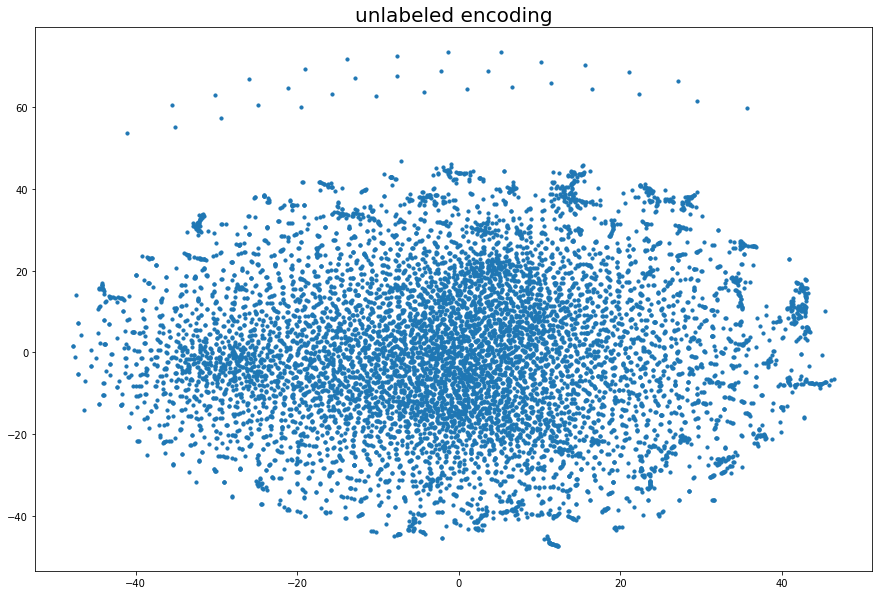

In [17]:
plot_tsne_df(tsne_df)

In [18]:
filename = 'data/acid_properties.csv'
props = pd.read_csv(filename)

In [19]:
######################

In [20]:
def acid_dict(some_c, props):
    prop_by_letter = [props[props.acid == let].iloc[:, 1:] for let in some_c]   
    df_concat = pd.concat(prop_by_letter)
    res = df_concat.mean()
    dres = dict(res)
    dres['acid'] = some_c
    return dres

In [21]:
save_path = 'data/all_acid_dicts.pickle'
producer = lambda: [acid_dict(some_c, props) for some_c in tsne_df.codone]
all_acid_dicts = read_or_create(save_path, producer)

reading data/all_acid_dicts.pickle


In [22]:
all_acid_df = pd.DataFrame(all_acid_dicts)
all_acid_df.head()

acid  hydrophobicity        mass  number_of_atoms      volume
0  DGG       -1.433333   76.396667        12.000000   77.100000
1  WEC       -0.633333  139.488933        20.000000  158.233333
2  QIC        1.166667  114.809900        18.666667  139.666667
3  HIE       -0.733333  126.470300        20.333333  152.766667
4  HIP       -0.100000  115.804033        19.666667  144.200000

In [23]:
final_df = all_acid_df.join(tsne_df.set_index('codone'), on='acid')
final_df.head()

acid  hydrophobicity        mass  number_of_atoms      volume         x0  \
0  DGG       -1.433333   76.396667        12.000000   77.100000   1.145444   
1  WEC       -0.633333  139.488933        20.000000  158.233333  34.693008   
2  QIC        1.166667  114.809900        18.666667  139.666667  -8.405204   
3  HIE       -0.733333  126.470300        20.333333  152.766667   5.201958   
4  HIP       -0.100000  115.804033        19.666667  144.200000   0.633364   

          x1  
0  19.600924  
1  13.960428  
2 -13.001018  
3 -11.678155  
4  -5.237406

In [24]:
def plot_embedding_properties(final_df):
    plt.figure(figsize=(25, 20))
    for i, p in enumerate(['hydrophobicity', 'mass', 'number_of_atoms', 'volume']):
        plt.subplot(2,2,i+1)
        plt.title(p, fontsize=25)
        plt.scatter(final_df.x0, final_df.x1, c=final_df[p], s=10)
    plt.show()

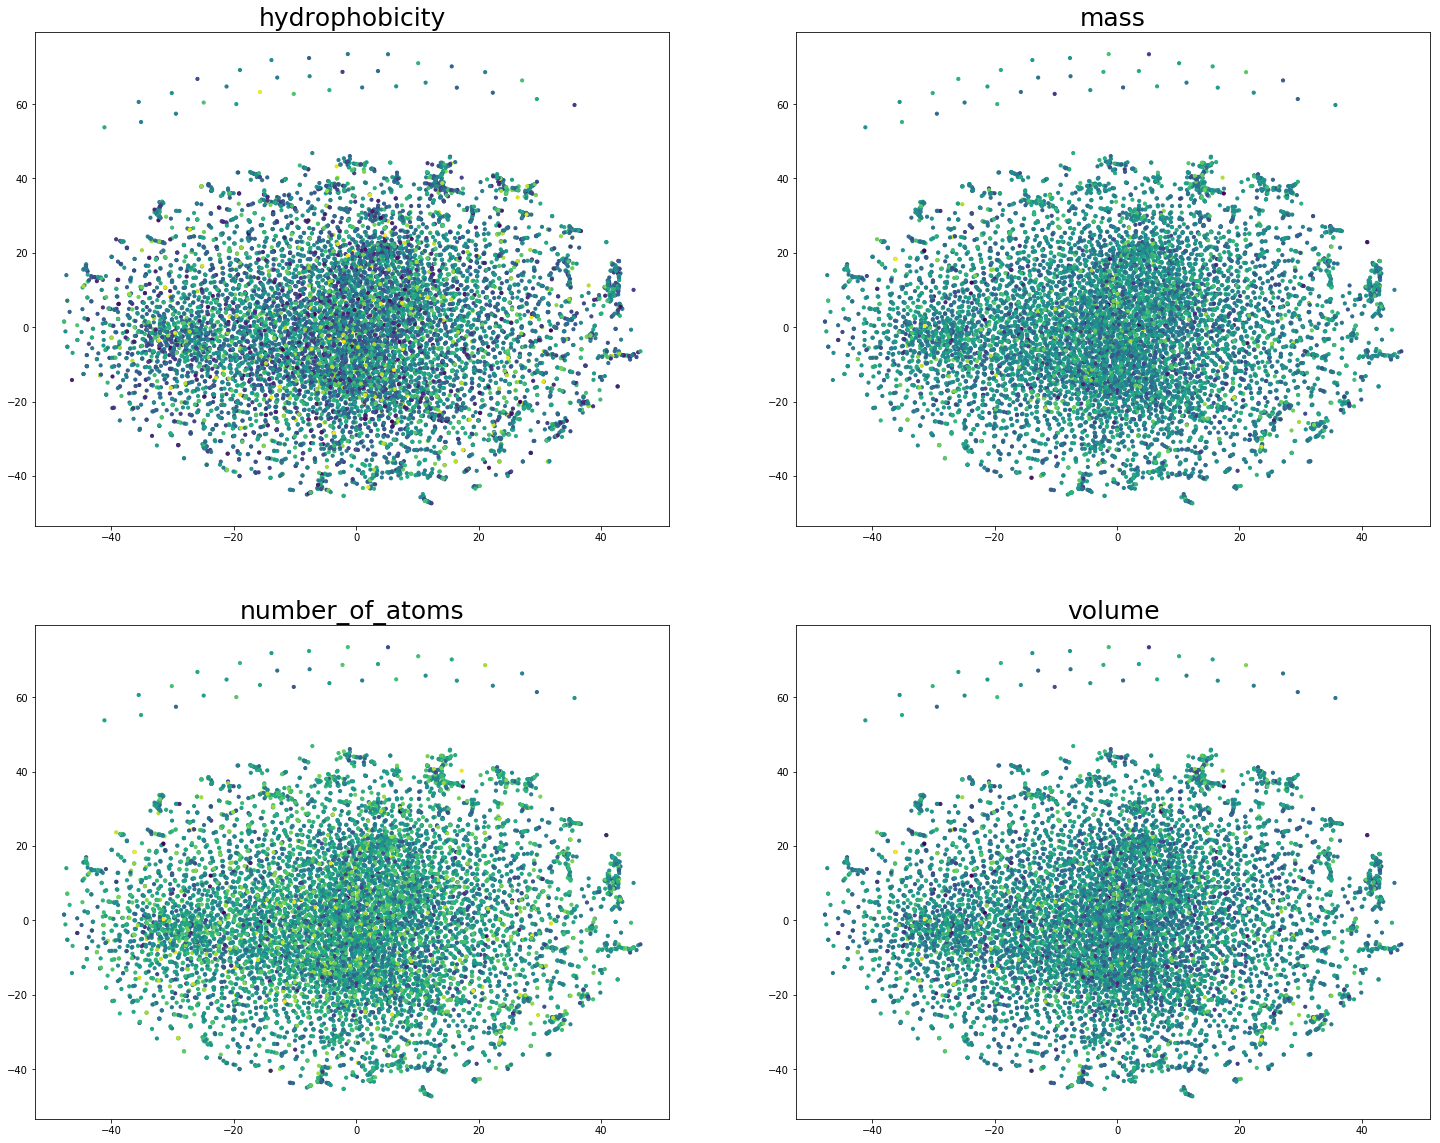

In [25]:
plot_embedding_properties(final_df)

In [28]:
######################

In [29]:
filename = 'data/nice_embed_tsne.csv'
gensim_tsne_df = pd.read_csv(filename, index_col=0)
gensim_tsne_df.columns = ['x0', 'x1', 'codone']

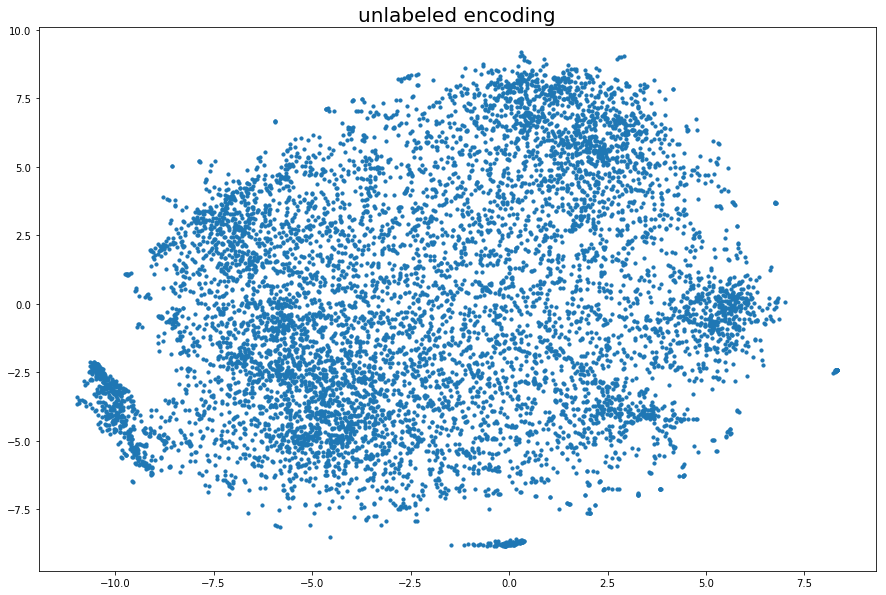

In [30]:
plot_tsne_df(gensim_tsne_df)

In [31]:
final_df_nice = all_acid_df.join(gensim_tsne_df.set_index('codone'), on='acid')

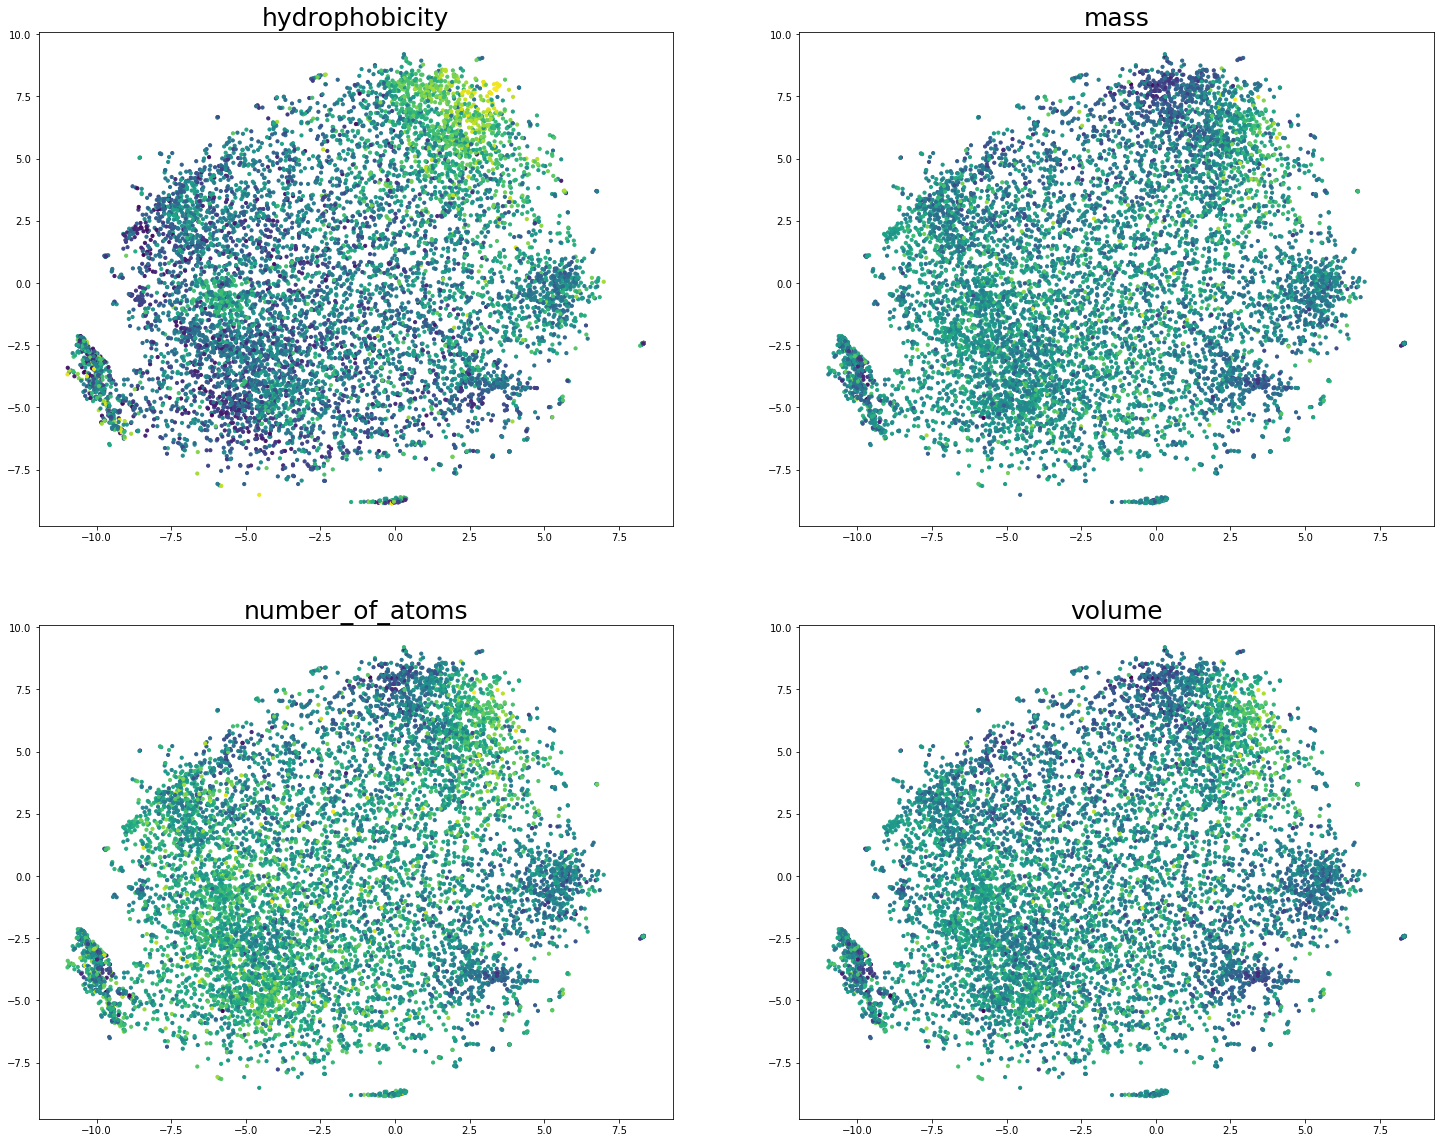

In [32]:
plot_embedding_properties(final_df_nice)

## Homework

* Implement in Pytorch and fine-tune this SkipGramModel to archive better embedding for amino acids codones. 
* Visualize your space in the similar style as on the bottom example. 
* Visualize 3D T-SNE in TensorboardX

Article with the original research can be found here http://journals.plos.org/plosone/article/file?id=10.1371/journal.pone.0141287&type=printable

Bonus task(no credit): visualize your embedding space in similar manner as minst example: https://www.tensorflow.org/versions/r0.12/how_tos/embedding_viz/

In [ ]:
soft deadline: 14.10.2018 at 23.59

hard deadline: 17.01.2018 at 23.59